In [1]:
import torch
# import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import trange
import numpy as np
from models.resnet_quat import ResNet18, ResNet34, ResNet50, ResNet101, ResNet152
from sklearn.metrics import accuracy_score

In [2]:
hparams = {
    "batch_size": 256,
    "num_epochs": 40,
    "model": "ResNet18",
    "dataset": "cifar100_coarse",
    "num_classes": 20,
    "optimizer": "sgd",
    "learning_rate": 0.005,
    "device": "cuda:0",
}  # although not all are actually hyperparameters

sync = False  # whether to sync with wandb

device = torch.device(hparams["device"])

In [3]:
train_file = f"../data/cifar100/coarse_train.csv" if hparams["dataset"] == "cifar100_coarse" else f"../data/cifar100/fine_train.csv"
test_file = f"../data/cifar100/coarse_test.csv" if hparams["dataset"] == "cifar100_coarse" else f"../data/cifar100/fine_test.csv"

train = pd.read_csv(train_file, header=None).values
x = torch.from_numpy(train[:, 1:].reshape(-1, 3, 32, 32).transpose((0, 3, 2, 1))/255).float()
y = torch.nn.functional.one_hot(torch.from_numpy(train[:, 0]).long(), hparams["num_classes"])

test = pd.read_csv(test_file, header=None).values
x_test = torch.from_numpy(test[:, 1:].reshape(-1, 3, 32, 32).transpose((0, 3, 2, 1))/255).float()
y_test = torch.nn.functional.one_hot(torch.from_numpy(test[:, 0]).long(), hparams["num_classes"])

mat = np.array(
    [
        [1, 0, 0, 0.299],
        [0, 1, 0, 0.587],
        [0, 0, 1, 0.144]
    ]
)  # RGB to RGB+Grayscale conversion matrix

x = torch.Tensor(np.dot(x, mat).transpose((0, 3, 1, 2))).float().to(device)
x_test = torch.Tensor(np.dot(x_test, mat).transpose((0, 3, 1, 2))).float().to(device)

In [4]:
if   hparams["model"] == "ResNet18" : model =  ResNet18(4, hparams["num_classes"])  # takes ~4.9s/epoch
elif hparams["model"] == "ResNet34" : model =  ResNet34(4, hparams["num_classes"])  # takes ~8.2s/epoch
elif hparams["model"] == "ResNet50" : model =  ResNet50(4, hparams["num_classes"])  
elif hparams["model"] == "ResNet101": model = ResNet101(4, hparams["num_classes"])
elif hparams["model"] == "ResNet152": model = ResNet152(4, hparams["num_classes"])
else: raise ValueError("Invalid model name")

model.to(device)
optimiser = torch.optim.Adam(model.parameters(), lr=hparams["learning_rate"])
losses = []
train_acc, test_acc = [], []

wandb_name = f"{hparams['model']}_{hparams['dataset']}_B={hparams['batch_size']}_O={hparams['optimizer']}_ll={hparams['learning_rate']}"

if sync:
    import wandb
    wandb.init(project="QuatLT23", name=wandb_name, config=hparams)
    wandb.watch(model)

In [5]:
batch_x = torch.from_numpy(np.random.rand(256, 4, 32, 32)).to(device)
batch_x.shape

torch.Size([256, 4, 32, 32])

In [6]:
output = model(batch_x.float())

/home/aritra/project/quatLT23/htorch/layers.py:591: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).mH().
This transform will produce equivalent results for all valid (symmetric positive definite) inputs. (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1691.)
  ell = torch.cholesky(cov + self.eye, upper=True)
/home/aritra/project/quatLT23/htorch/layers.py:592: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered intern

In [7]:
num_epochs = hparams["num_epochs"]
batch_size = hparams["batch_size"]

for epoch in trange(num_epochs):
    # print("Training")
    for i in range(0, len(x), batch_size):
        batch_x, batch_y = x[i:i+batch_size].to(device), y[i:i+batch_size].float().to(device)
        optimiser.zero_grad()
        output = model(batch_x)
        # print(f"{output.shape = }, {batch_y.shape = }")
        loss = F.mse_loss(output, batch_y)
        loss.backward()
        optimiser.step()
    losses.append(loss.item())

    train_accs, test_accs = [], []
    batch_size_acc = 1000

    # print("Calculating Accuracy")

    for i in range(0, len(x), batch_size_acc):
    # for i in range(0, 1000, batch_size_acc):
        batch_x, batch_y = x[i:i+batch_size_acc].to(device), y[i:i+batch_size_acc].numpy()
        train_pred = model(batch_x)
        acc = accuracy_score(batch_y.argmax(1), train_pred.argmax(1).cpu().numpy())
        train_accs.append(acc*100)
    train_acc.append(np.array(train_accs).mean())
    # print(f"Train Accuracy: {train_acc[-1]:.2f}%")

    for i in range(0, len(x_test), batch_size_acc):
    # for i in range(0, 1000, batch_size_acc):
        batch_x_test, batch_y_test = x_test[i:i+batch_size_acc].to(device), y_test[i:i+batch_size_acc].numpy()
        test_pred = model(batch_x_test)
        acc = accuracy_score(batch_y_test.argmax(1), test_pred.argmax(1).cpu().numpy())
        test_accs.append(acc*100)
    test_acc.append(np.array(test_accs).mean())
    # print(f"Test Accuracy: {test_acc[-1]:.2f}%")

    if sync: wandb.log(
        {
            "train_acc": train_acc[-1],
            "test_acc": test_acc[-1],
            "loss": loss.item(),
        }
    )

100%|██████████| 40/40 [16:49<00:00, 25.23s/it]


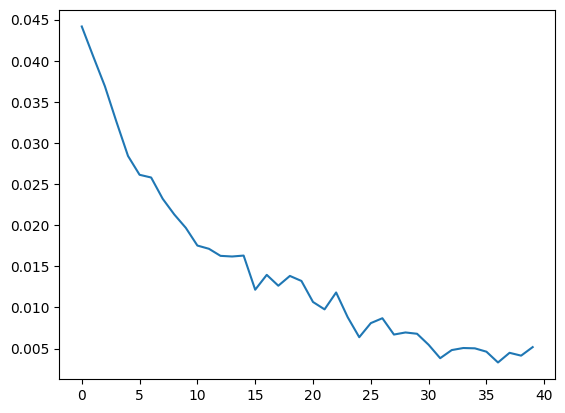

In [8]:
plt.plot(losses)

Text(0.5, 1.0, 'Quat')

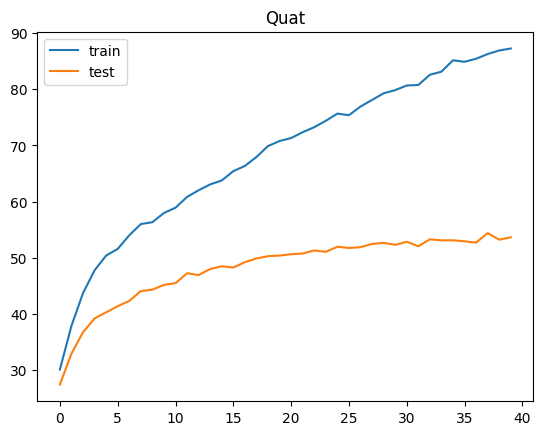

In [12]:
plt.plot(train_acc, label="train")
plt.plot(test_acc, label="test")
plt.legend()
plt.title("Quat")

In [10]:
if sync: torch.save(model, f"saved_models/{wandb_name}_E={hparams['num_epochs']}.pth")

In [11]:
if sync: wandb.finish()